### South Pacific Ocean Parcels Simulation
Advect a set of coordinates using Ocean surface current estimates

#### Import required python libraries

In [41]:
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4
import cartopy
import numpy as np
import math
from datetime import timedelta, datetime
from operator import attrgetter
import xarray as xr
##- Custom functions
from model_utils import *
from geo_utils import *
from parcels_utils import *

#### Initialize parameters

In [42]:
run_days = None     ##- Number of days to run simulation, if None then default to entire model time bounds
stime = None        ##- Time to begin simulation, defaults to T0 in dataset '2022-06-14T22:21:00Z'

#### Define input/output data sources

In [43]:
fname_pts = './input/south-pacific-points.txt'
fname_model = '/tmp/hycom_latest.nc'
##- Define output fname
ofname = '/tmp/hycom_parcels_output.nc'

#### Read input points and create bounding region of interest (ROI)

In [109]:
buf = 4.0                                        ##- Buffer to extend ROI (degrees)
P = read_csv(fname_pts)                           ##- Function found in geo_utils.py
bbox = bounding_box(P['lat'],P['lon'],buf)        ##- Function found in geo_utils.py

In [110]:
P

{'lat': [7.006, 11.14, 13.807, 11.07, 12.29],
 'lon': [134.586, 133.93, 144.354, 140.74, 142.56]}

#### Particle coordinates

In [111]:
##- Particle coords
plat = P['lat'][0]
plon = P['lon'][0]

#### Open and subset HYCOM model data source

In [112]:
dset = get_hycom_data(fname_model)
dset = hycom_subset(dset,bbox['lon'],bbox['lat'])

In [113]:
dset

<xarray.Dataset>
Dimensions:  (time: 41, lat: 370, lon: 230)
Coordinates:
  * time     (time) datetime64[ns] 2023-05-09T12:00:00 ... 2023-05-14T12:00:00
    depth    float64 0.0
  * lat      (lat) float64 3.04 3.08 3.12 3.16 3.2 ... 17.68 17.72 17.76 17.8
  * lon      (lon) float64 130.0 130.1 130.2 130.2 ... 148.1 148.2 148.2 148.3
Data variables:
    water_u  (time, lat, lon) float32 ...
    water_v  (time, lat, lon) float32 ...
Attributes: (12/18)
    classification_level:      UNCLASSIFIED
    distribution_statement:    Approved for public release. Distribution unli...
    downgrade_date:            not applicable
    classification_authority:  not applicable
    institution:               Fleet Numerical Meteorology and Oceanography C...
    source:                    HYCOM archive file
    ...                        ...
    location:                  Proto fmrc:GLBy0.08_930_FMRC
    History:                   Translated to CF-1.0 Conventions by Netcdf-Jav...
    geospatial_lat_min:        1.0
    geospatial_lat_max:        40.0
    geospatial_lon_min:        110.0
    geospatial_lon_max:        170.0

#### Set up parameters for parcels to run

In [114]:
variables = { 'U':'water_u','V':'water_v'}
dimensions = { 'lat':'lat','lon':'lon','time':'time'}
start_dt = stime
if (not run_days):
    run_days = get_model_runtime(dset.time.data)

In [115]:
print("Simulation will run for "+str(run_days)+" days.")

Simulation will run for 5.0 days.


#### Create a Parcels FieldSet object using vars/dims

In [116]:
fieldset = FieldSet.from_xarray_dataset(dset,variables,dimensions)

Check out fieldset

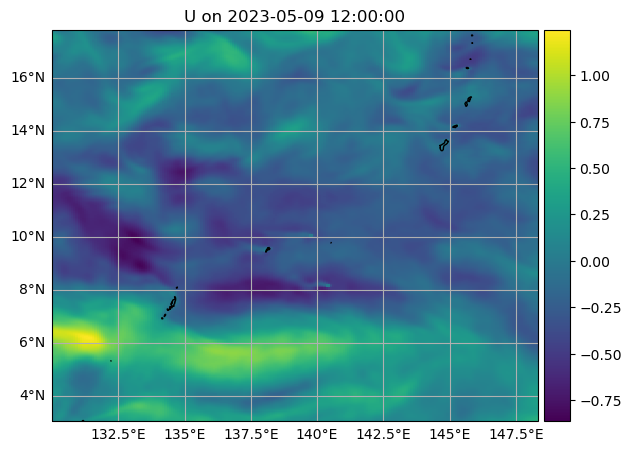

In [117]:
fieldset.U.show()

#### Create Parcels ParticleSet from input point list

In [118]:
pset = ParticleSet.from_list(fieldset=fieldset, 
                             pclass=JITParticle, 
                             lon=P['lon'], 
                             lat=P['lat'], 
                             time=start_dt)

In [119]:
print(pset)

P[26](lon=134.585999, lat=7.006000, depth=0.000000, time=not_yet_set)
P[27](lon=133.929993, lat=11.140000, depth=0.000000, time=not_yet_set)
P[28](lon=144.354004, lat=13.807000, depth=0.000000, time=not_yet_set)
P[29](lon=140.740005, lat=11.070000, depth=0.000000, time=not_yet_set)
P[30](lon=142.559998, lat=12.290000, depth=0.000000, time=not_yet_set)


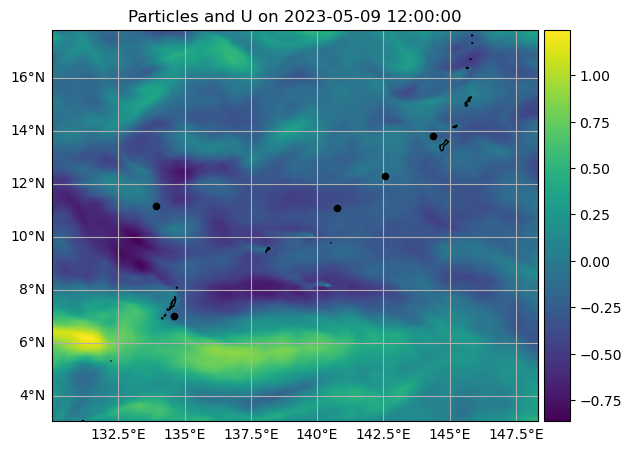

In [120]:
pset.show(field=fieldset.U)

#### Advect the particles through fieldset time/space

In [121]:
pset.execute(AdvectionRK4,
             runtime=timedelta(days=run_days),
             dt=timedelta(minutes=10))

INFO: Compiled ArrayJITParticleAdvectionRK4 ==> /tmp/parcels-1000/lib3fef3001c9a7416b4dd1d569a9638b52_0.so


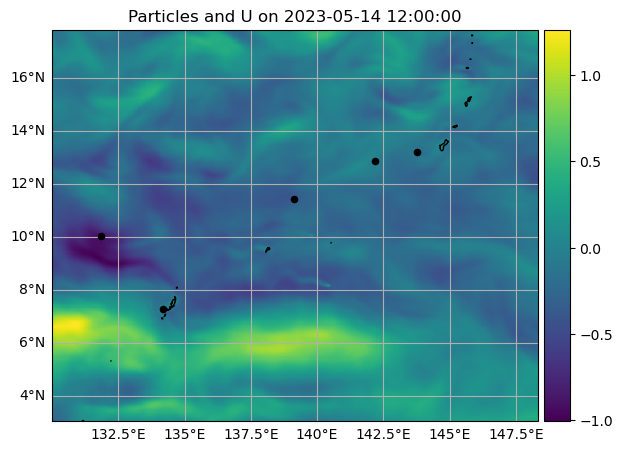

In [122]:
#pset.show(field='vector', vmax=2.0, domain={'N':15, 'S':5, 'E':150, 'W':130})
pset.show(field=fieldset.U)

In [ ]:
output_file.export()